In [1]:
import numpy as np

Import Data

In [2]:
training_data = [] # Features per class
training_labels = [] # Labels
testing_data = [] # Features per class
testing_labels = [] # Labels
N = 5250 # Amount of data we want to use max: 5250

# Import the features
with open("traindata.txt", "r") as file:
    for line in file.readlines():
        features = [float(i) for i in line.split(",")]
        training_data.append(features)

with open("testdata.txt", "r") as file:
    for line in file.readlines():
        features = [float(i) for i in line.split(",")]
        testing_data.append(features)


# Import the labels
with open("trainlabels.txt", "r") as file:
    for line in file.readlines():
        label = float(line.rstrip())
        training_labels.append(label)

with open("targetlabels.txt", "r") as file:
    for line in file.readlines():
        label = float(line.rstrip())
        testing_labels.append(label)

# Convert data to numpy arrays
training_data = np.array(training_data)
training_labels = np.array(training_labels, dtype=np.int64)

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels, dtype=np.int64)

In [3]:
print("Training Data: ", training_data.shape, training_labels.shape)
print("Testing Data: ", testing_data.shape, testing_labels.shape)

Training Data:  (5250, 1041) (5250,)
Testing Data:  (2100, 1041) (2100,)


### Preprocess Data

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
def to_onehot(x):
    labels = np.unique(x)
    result = np.zeros(shape=(x.shape[0], labels.shape[0]))

    for i in range(len(x)):
        result[i][x[i]] = 1.0

    return result

def rotate_image(image, orientation):
    angle = 90 * orientation
    
    if angle == 0:
        return image
    elif angle == 90:
        return np.fliplr(np.transpose(image))  # Rotate 90 degrees clockwise
    elif angle == 180:
        return np.flipud(np.fliplr(image))  # Rotate 180 degrees
    elif angle == 270:
        return np.transpose(np.fliplr(image))  # Rotate 270 degrees clockwise

def preprocess_data(X):
    x = X[:-1]
    orientation = X[-1] # 4 orientations: 0, 1, 2, 3

    filtered_x = x[x >= 0] # Filter out negative values
    filtered_x = np.minimum(filtered_x, 255.0) # cap values greater than 255 to 255
    image = filtered_x.reshape([32, 32]) # reshape to an image

    normalized_image = MinMaxScaler().fit_transform(image) # Normalize Image

    rotated_image = rotate_image(normalized_image, orientation) #Rotate Image
    return rotated_image

In [6]:
preprocess_training_data = []
preprocess_testing_data = []

for X in training_data:
    preprocess_X = preprocess_data(X)
    preprocess_training_data.append(preprocess_X)

for X in testing_data:
    preprocess_X = preprocess_data(X)
    preprocess_testing_data.append(preprocess_X)

### Split Data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
def split_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
   
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Further splitting the training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size / (1 - test_size),
                                                      random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train = np.array(preprocess_training_data)
y_train = to_onehot(training_labels)
X_test, X_val, y_test, y_val = train_test_split(np.array(preprocess_testing_data), to_onehot(testing_labels), test_size=0.5, random_state=42)

#### Reshaping Data

In [9]:
new_shape = [-1, 1, 32, 32]
X_train = np.reshape(X_train, new_shape)
X_test = np.reshape(X_test, new_shape)
X_val = np.reshape(X_val, new_shape)

print(X_train.shape, X_test.shape, X_val.shape)

(5250, 1, 32, 32) (1050, 1, 32, 32) (1050, 1, 32, 32)


### Visualize Data

In [10]:
import matplotlib.pyplot as plt

In [11]:
def plot_images(image, title):
    plt.imshow(image.reshape([32, 32]), cmap="gray")
    plt.title(title)
    plt.show()

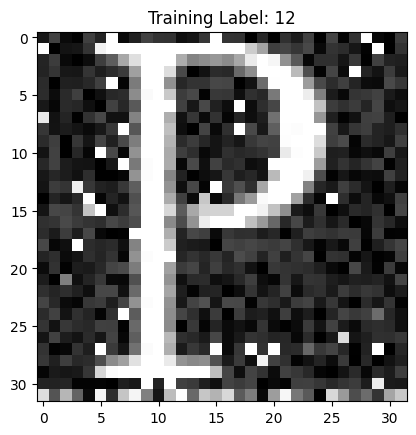

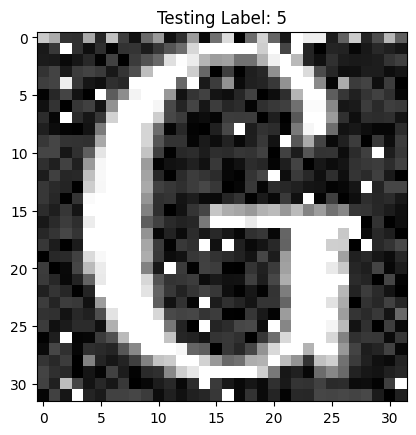

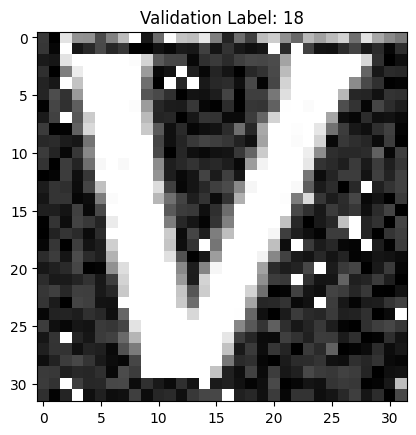

In [12]:
data_point = 14
plot_images(X_train[data_point], f"Training Label: {np.argmax(y_train[data_point])}")
plot_images(X_test[data_point], f"Testing Label: {np.argmax(y_test[data_point])}")
plot_images(X_val[data_point], f"Validation Label: {np.argmax(y_val[data_point])}")

Build Model

In [13]:
import torch as T
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_dims, n_outputs, p_dropout=0.20, save_dir="./models"):
        super(NeuralNetwork, self).__init__()
        self.save_dir = save_dir

        activation = nn.ReLU()
        dropout = nn.AlphaDropout(p=p_dropout)

        # Define layers with expected sizes
        self.network = nn.Sequential(
            nn.Conv2d(1, input_dims[0], kernel_size=3, padding=1),  # Input shape: (1, 32, 32)
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (32, 16, 16)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output shape: (64, 16, 16)
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (64, 8, 8)
            
            nn.Flatten(),
            nn.Linear(in_features=64 * 8 * 8, out_features=1024),
            activation,
            dropout,
            nn.Linear(in_features=1024, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=256),
            activation,
            dropout,
            nn.Linear(in_features=256, out_features=n_outputs),
        )

    def forward(self, X):
        logits = self.network(X)
        return logits

    def save(self, name):
        T.save(self.state_dict(), f"{self.save_dir}/{name}.pth")

    def load(self, name):
        self.load_state_dict(T.load(f"{self.save_dir}/{name}.pth"))


# Adjust dimensions for input and output
n_inputs = [32, 32]  # Width and height of the input image
n_outputs = 21  # Number of output classes

# Move a tensor to the GPU
device = T.device("cuda" if T.cuda.is_available() else "cpu")

# Initialize the model
model_1 = NeuralNetwork(input_dims=n_inputs, n_outputs=n_outputs, p_dropout=0.2).to(device)
model_2 = NeuralNetwork(input_dims=n_inputs, n_outputs=n_outputs, p_dropout=0.2).to(device)

dummy_image = T.rand(size=[1, 1, n_inputs[0], n_inputs[1]]).to(device)  # Dummy image tensor
pred_1 = model_1(dummy_image)
pred_2 = model_2(dummy_image)

print(pred_1, pred_2)


tensor([[-1.1977e-01, -4.6321e-01, -1.1619e-01, -3.5213e-01,  2.9254e-01,
         -1.1731e-01,  1.6064e-01, -1.9959e-01,  4.3162e-01, -3.1179e-01,
          1.0710e-01, -2.9522e-01,  1.6489e-02,  5.9222e-01, -1.3422e-02,
          2.5963e-01, -5.0496e-01,  3.1828e-04,  7.9348e-01,  3.3878e-01,
         -2.1540e-01]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[-1.0081, -0.5935,  0.4110,  0.4287, -0.5451,  0.4829,  0.5080,  0.1244,
         -0.9110, -1.1962, -0.0795, -0.1815, -0.0031, -0.4172,  0.9496,  0.4046,
          0.7607,  0.4041,  0.0348,  0.2260, -0.3511]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


## Ensembling

In [14]:
class Ensemble(nn.Module):
    def __init__(self, model_1, model_2, n_inputs, n_outputs, save_dir="./models"):
        super(Ensemble, self).__init__()
        self.save_dir = save_dir

        self.model_1 = model_1
        self.model_2 = model_2

        activation = nn.ReLU()
        dropout = nn.Dropout(p=0.4)

        self.classifier = nn.Sequential(
            activation,
            nn.Linear(in_features=n_inputs, out_features=256),
            activation,
            dropout,
            nn.Linear(in_features=256, out_features=128),
            activation,
            dropout,
            nn.Linear(in_features=128, out_features=n_outputs)
        )
    
    def forward(self, x):
        x_1 = self.model_1(x.clone())
        x_2 = self.model_2(x.clone())

        x = T.cat([x_1, x_2], dim=1)
        logits = self.classifier(x)
        return logits
    
    def save(self, name):
        T.save(self.state_dict(), f"{self.save_dir}/{name}.pth")

    def load(self, name):
        self.load_state_dict(T.load(f"{self.save_dir}/{name}.pth"))


model_1.save_dir = "./models"
model_2.save_dir = "./models"

#Freeze these models 
model_1.load("Conv-NeuralNetwork-Image Dataset-1_acc-80.00_loss-0.000001")
for param in model_1.parameters():
    param.requires_grad_(False)

model_2.load("Conv-NeuralNetwork-Image Dataset-2_acc-80.19_loss-0.000001")
for param in model_2.parameters():
    param.requires_grad_(False)

model = Ensemble(model_1, model_2, 42, 21).to(device)


Train Model

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, cohen_kappa_score
import torch.nn.functional as F

In [17]:
def validate_model(model, X_val, y_val, criterion):
    size = len(y_val)

    model.eval()

    with T.no_grad():
        X = T.from_numpy(X_val).to(T.float32).to(device)
        y_true = T.Tensor(y_val).to(T.float).to(device)

        logits = model.forward(X)

        loss = criterion(logits, y_true)

        y_pred = logits.argmax(1).cpu().numpy()
        y_true = y_true.argmax(1).cpu().numpy()

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        roc_auc = roc_auc_score(y_true, F.softmax(logits, dim=1).cpu().numpy(), multi_class='ovo')
        cohen_kappa = cohen_kappa_score(y_true, y_pred)
        
        loss /= size
        
        print(f"Validation Metrics: \n Accuracy: {100 * accuracy:>0.2f}%, Precision: {precision:>0.4f}, Recall: {recall:>0.4f}, ROC AUC: {roc_auc:>0.4f}, Cohen Kappa: {cohen_kappa:>0.4f}, Avg loss: {loss:>8f}")
    
    return accuracy, loss

In [18]:
def train_model(model, X_train, y_train, criterion, optimizer):
    size = len(X_train)
    batch_size = 141

    #Prevents model from memorizing the position of data
    indices = np.random.randint(0, size, size)

    model.train()

    for i in range(size//batch_size):
        start = batch_size * i
        end = start + batch_size

        X = T.from_numpy(X_train[indices[start:end]]).to(T.float32).to(device)
        y_true = T.Tensor(y_train[indices[start:end]]).to(T.float).to(device)

        logits = model.forward(X)
        
        loss = criterion(logits, y_true)

        # Gradiant Descent using Adam optimizer for best performance
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct = (logits.argmax(1) == y_true.argmax(1)).type(T.float).sum().item()
        accuracy = correct/batch_size

        if (i * batch_size) % 564 == 0:
            loss, current = loss.item(), (i + 1) * batch_size
            print(f"Accuracy: {(100 * (accuracy)):>0.1f}%, Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [18]:
import torch.optim as optim

# Global Variables
epochs = 1_000
learning_rate = 1e-4

# Load Pre-Trained Models
# model_1.load("NeuralNetwork-1_acc-50.29_loss-0.000003")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_accuracy = 0.80 # ???

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    train_model(model, X_train, y_train, criterion, optimizer)
    print('Finished training')
    
    accuracy, loss = validate_model(model, X_val, y_val, criterion)

    if accuracy > best_accuracy:
        print(f"[+] Saving Model...")
        model.save(f"Conv-NeuralNetwork-Ensemble-Advance_acc-{accuracy * 100:.2f}_loss-{loss:>8f}")
        best_accuracy = accuracy

        print(f"[!] Models Saved.")

    epoch += 1


Epoch 1
-------------------------------
Accuracy: 7.1%, Loss: 4.143784 [  141/ 5250]
Accuracy: 3.5%, Loss: 4.099166 [  705/ 5250]
Accuracy: 5.0%, Loss: 4.145131 [ 1269/ 5250]
Accuracy: 5.7%, Loss: 3.792129 [ 1833/ 5250]
Accuracy: 11.3%, Loss: 3.389846 [ 2397/ 5250]
Accuracy: 14.9%, Loss: 3.211211 [ 2961/ 5250]
Accuracy: 12.8%, Loss: 3.066962 [ 3525/ 5250]
Accuracy: 14.9%, Loss: 2.948876 [ 4089/ 5250]
Accuracy: 17.7%, Loss: 2.764198 [ 4653/ 5250]
Accuracy: 22.7%, Loss: 2.734777 [ 5217/ 5250]
Finished training


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Metrics: 
 Accuracy: 55.33%, Precision: 0.5681, Recall: 0.5489, ROC AUC: 0.9263,  Avg loss: 0.001564
Epoch 2
-------------------------------
Accuracy: 21.3%, Loss: 2.783886 [  141/ 5250]
Accuracy: 24.8%, Loss: 2.628974 [  705/ 5250]
Accuracy: 27.7%, Loss: 2.381369 [ 1269/ 5250]
Accuracy: 34.8%, Loss: 2.318147 [ 1833/ 5250]
Accuracy: 39.7%, Loss: 2.161101 [ 2397/ 5250]
Accuracy: 33.3%, Loss: 2.211359 [ 2961/ 5250]
Accuracy: 41.8%, Loss: 2.127930 [ 3525/ 5250]
Accuracy: 39.0%, Loss: 2.113221 [ 4089/ 5250]
Accuracy: 51.8%, Loss: 1.820678 [ 4653/ 5250]
Accuracy: 55.3%, Loss: 1.701710 [ 5217/ 5250]
Finished training


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Metrics: 
 Accuracy: 75.81%, Precision: 0.7358, Recall: 0.7579, ROC AUC: 0.9634,  Avg loss: 0.000958
Epoch 3
-------------------------------
Accuracy: 47.5%, Loss: 1.805533 [  141/ 5250]
Accuracy: 58.2%, Loss: 1.687569 [  705/ 5250]
Accuracy: 55.3%, Loss: 1.723815 [ 1269/ 5250]
Accuracy: 58.2%, Loss: 1.574065 [ 1833/ 5250]
Accuracy: 68.1%, Loss: 1.422697 [ 2397/ 5250]
Accuracy: 63.8%, Loss: 1.459132 [ 2961/ 5250]
Accuracy: 66.0%, Loss: 1.490637 [ 3525/ 5250]
Accuracy: 70.2%, Loss: 1.474634 [ 4089/ 5250]
Accuracy: 68.8%, Loss: 1.459722 [ 4653/ 5250]
Accuracy: 72.3%, Loss: 1.257228 [ 5217/ 5250]
Finished training
Test Metrics: 
 Accuracy: 79.43%, Precision: 0.7951, Recall: 0.7941, ROC AUC: 0.9665,  Avg loss: 0.000943
Epoch 4
-------------------------------
Accuracy: 67.4%, Loss: 1.396408 [  141/ 5250]
Accuracy: 73.0%, Loss: 1.150602 [  705/ 5250]
Accuracy: 72.3%, Loss: 1.267125 [ 1269/ 5250]
Accuracy: 72.3%, Loss: 1.279743 [ 1833/ 5250]
Accuracy: 78.0%, Loss: 1.050426 [ 2397/ 5250]


KeyboardInterrupt: 

Testing Model

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def make_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    plt.show()

In [20]:

criterion = nn.CrossEntropyLoss()
def test_model(model, X_test, y_test, criterion):
    size = len(y_test)
    loss = 0
    model.eval()
    with T.no_grad():
        X = T.from_numpy(X_test).to(T.float32).to(device)
        y_true = T.Tensor(y_test).to(T.float).to(device)

        logits = model.forward(X)

        loss = criterion(logits, y_true)

        y_pred = logits.argmax(1).cpu().numpy()
        y_true = y_true.argmax(1).cpu().numpy()
        labels = np.unique(y_true)
        
        make_confusion_matrix(y_pred, y_true, labels)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        roc_auc = roc_auc_score(y_true, F.softmax(logits, dim=1).cpu().numpy(), multi_class='ovo')
        cohen_kappa = cohen_kappa_score(y_true, y_pred)
        
        loss /= size
        
        print(f"Test Metrics: \n Accuracy: {100 * accuracy:>0.2f}%, Precision: {precision:>0.4f}, Recall: {recall:>0.4f}, ROC AUC: {roc_auc:>0.4f}, Cohen Kappa: {cohen_kappa:>0.4f}, Avg loss: {loss:>8f}")
    
    return accuracy, loss

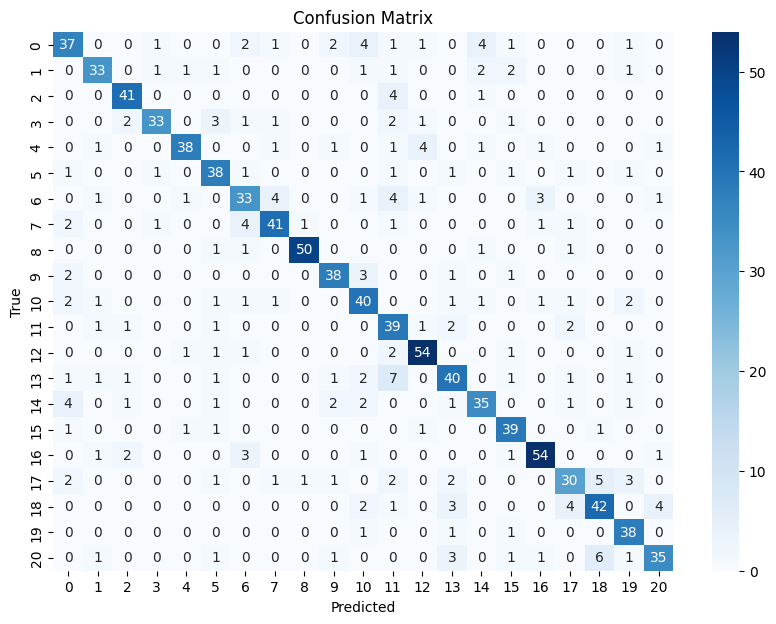

Test Metrics: 
 Accuracy: 78.86%, Precision: 0.7927, Recall: 0.7893, ROC AUC: 0.9705, Cohen Kappa: 0.7779, Avg loss: 0.001719


(0.7885714285714286, tensor(0.0017, device='cuda:0'))

In [21]:
# model_1.save_dir = "./best_models"
# model_2.save_dir = "./best_models"

model.load("Conv-NeuralNetwork-Ensemble-Advance_acc-80.67_loss-0.001625")
# model_2.load("NeuralNetwork-2_acc-61.81_loss-0.000008")
test_model(model, X_test, y_test, criterion)